# Plot

In [36]:
from pathlib import Path
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json

from processing_utils import xyz_to_df, pairwise_distance, average_abs_dist, xyz_to_np

HARTREE_TO_KCAL_MOL = 627.509

In [37]:
experiments_path = Path("experiments")
processed_results_path = Path("processed_results")
molecules_path = Path("uniques_100_molecules_42_seed")

In [38]:
results_df = pd.read_csv(processed_results_path / "with_reference_results.csv")
results_df.head()

,molecule,parameter,factor,parameter value,atomisation energy (Hartrees),atomisation energy (kcal/mol),total energy (Hartrees),total energy (kcal/mol),pairwise distance,atoms,...,VQM24 atomisation energy (kcal/mol),VQM24 total energy (Hartrees),VQM24 total energy (kcal/mol),VQM24 pairwise distance,Atomization Energy MAE (Hartrees),Atomization Energy MAE (kcal/mol),Total Energy MAE (Hartrees),Total Energy MAE (kcal/mol),Pairwise Distance MAE,Pairwise Distance Frobenius Norm
0,BrSSiSxH3_2,kexplight,1.2,1.2,0.707659,444.062183,13.650865,8566.040903,[[0. 2.4478647 3.84235109 3.80631572 ...,"['S', 'Si', 'Br', 'S', 'H', 'H', 'H']",...,446.295146,5.835438,3661.789619,[[0. 2.60401351 3.52360586 3.66534548 ...,0.003558,2.232964,7.815428,4904.251284,0.697765,6.242887
1,C2ClFSxH4_22,kexplight,1.2,1.2,1.613221,1012.310525,18.675790,11719.226458,[[0. 1.33909887 2.70844351 4.16060165 ...,"['F', 'C', 'S', 'Cl', 'C', 'H', 'H', 'H', 'H']",...,693.249515,1.652139,1036.731911,[[0. 1.33368057 2.74667576 4.29145943 ...,0.508456,319.061010,17.023652,10682.494547,0.058493,0.801000
2,BrO2P2H3_8,kexplight,1.2,1.2,1.548242,971.535771,18.770090,11778.400337,[[0. 1.64807548 2.58868447 2.79816368 ...,"['P', 'O', 'O', 'P', 'Br', 'H', 'H', 'H']",...,488.052273,5.432418,3408.891139,[[0. 1.69949596 2.59658549 3.88260912 ...,0.770481,483.483497,13.337672,8369.509198,0.304710,3.678716
3,ClOP3H0_1,kexplight,1.2,1.2,1.216244,763.204064,16.157681,10139.090245,[[0. 1.4579271 2.97711075 4.32077894 ...,"['O', 'P', 'P', 'P', 'Cl']",...,312.381174,2.485124,1559.437989,[[0. 1.50714837 3.11019516 2.98535046 ...,0.718433,450.822890,13.672556,8579.652256,0.293298,2.366234
4,CN2PSH1_54,kexplight,1.2,1.2,1.767130,1108.890292,14.221133,8923.888752,[[0. 1.66597269 2.46696645 2.57048717 ...,"['N', 'P', 'N', 'S', 'C', 'H']",...,531.570446,1.414629,887.692235,[[0. 1.70221179 2.56445994 2.59656752 ...,0.920018,577.319846,12.806504,8036.196517,0.032146,0.230476


## Atomisation Energy

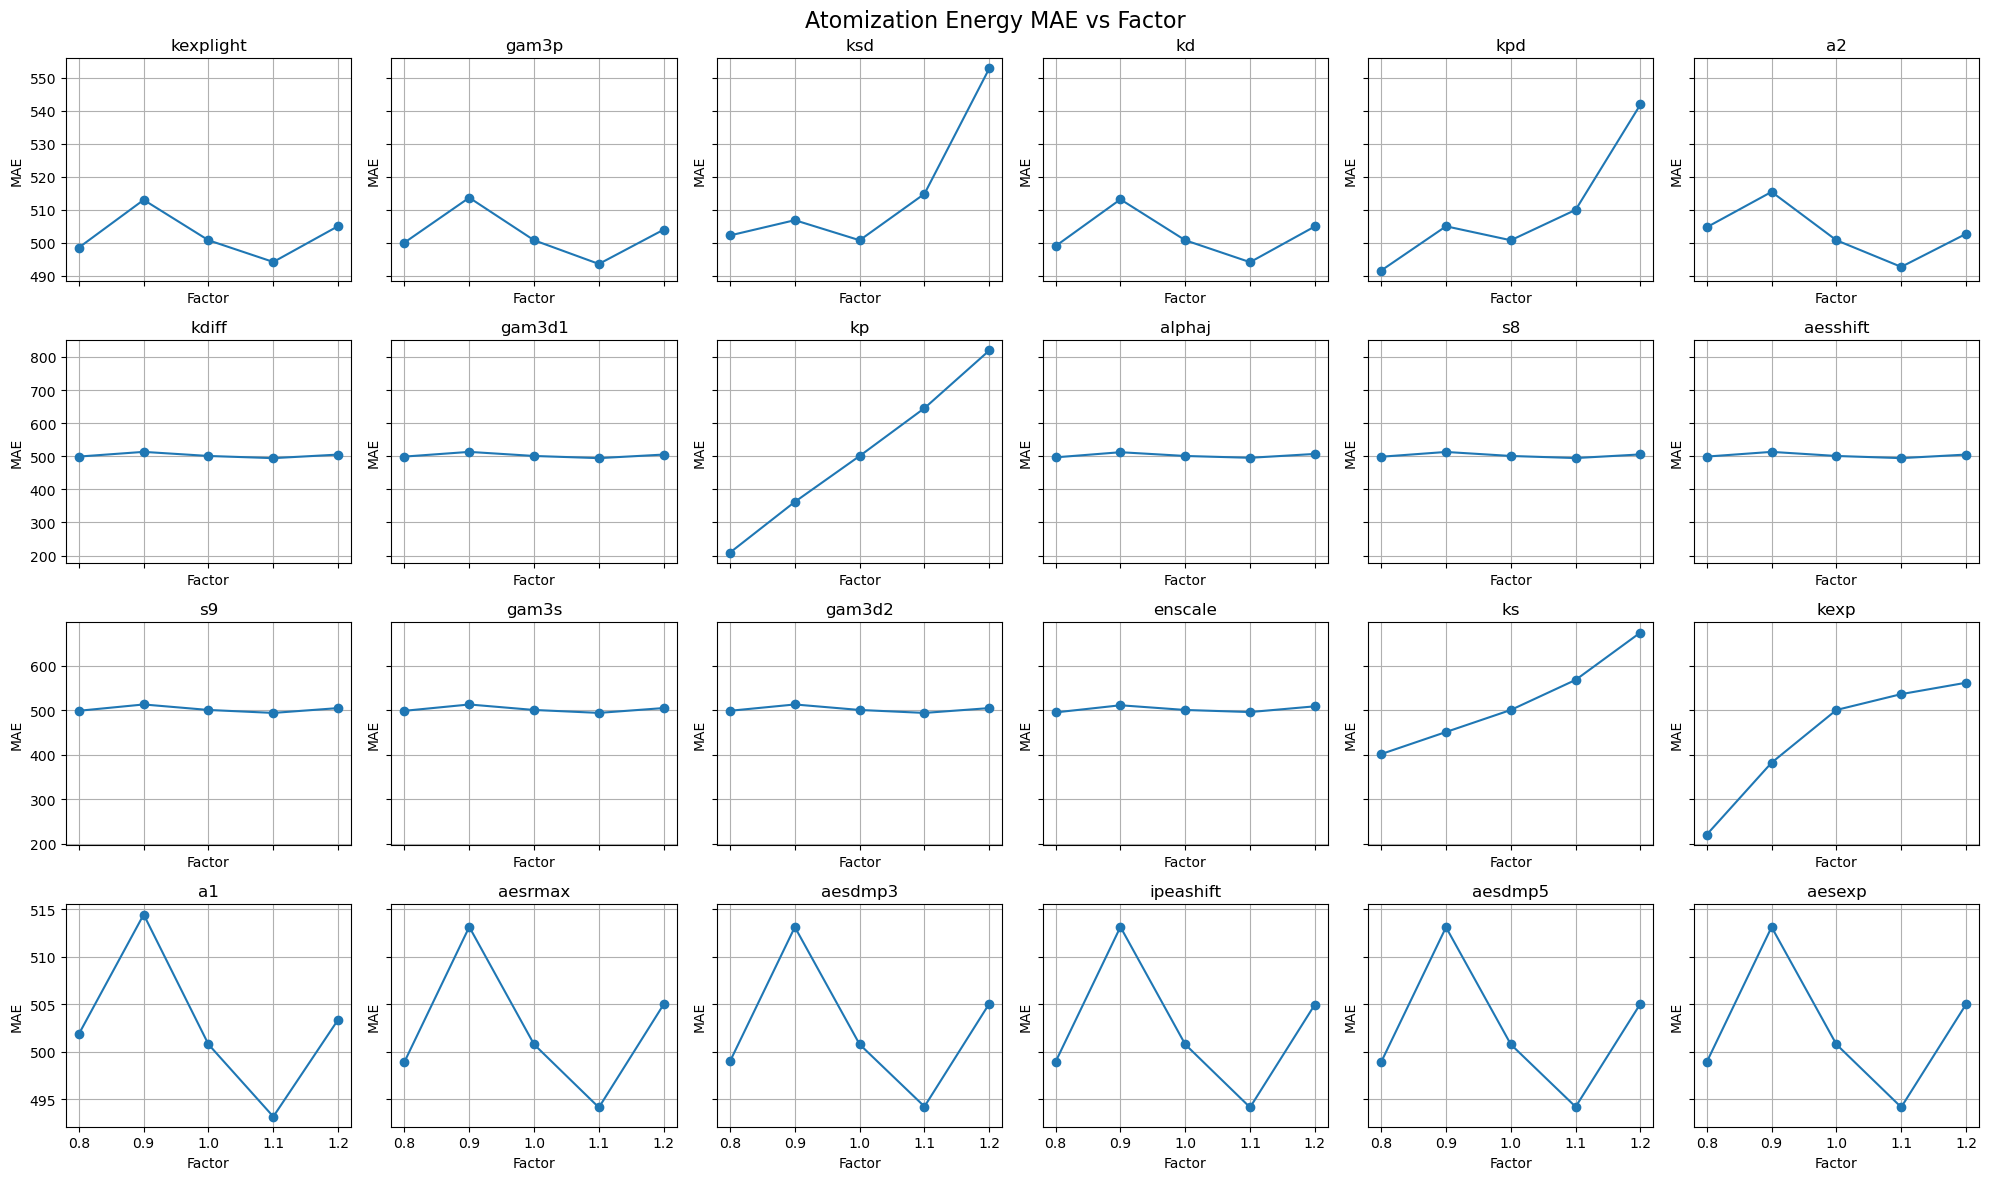

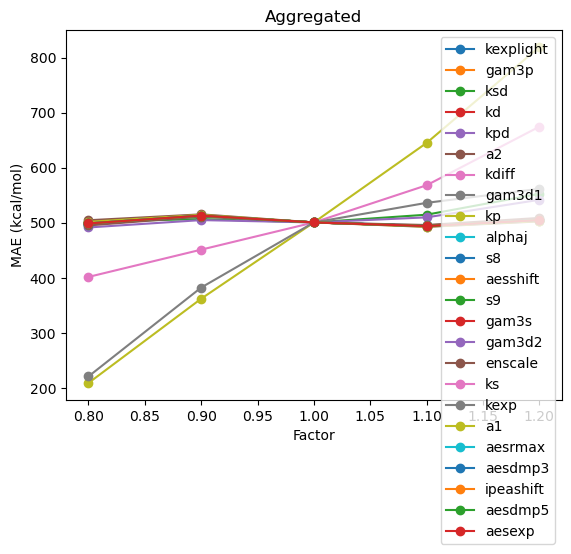

In [39]:
num_rows, num_cols = (4, 6)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

aggregated_fig, aggregated_axs = plt.subplots()

molecule_sets = {}
for factor in results_df["factor"].unique():
    factor_df = results_df[results_df["factor"] == factor]
    molecule_sets[factor] = factor_df["molecule"].unique()
    for parameter in factor_df["parameter"].unique():
        parameter_df = factor_df[factor_df["parameter"] == parameter]
        molecule_sets[factor] = np.intersect1d(
            molecule_sets[factor], parameter_df["molecule"].unique()
        )

for i, parameter in enumerate(results_df["parameter"].unique()):
    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]
        factor_df = factor_df[factor_df["molecule"].isin(molecule_sets[factor])]

        errors.append(
            (factor, factor_df["Atomization Energy MAE (kcal/mol)"].abs().mean())
        )

    ax = axs[i // num_cols, i % num_cols]

    errors.sort(key=lambda x: x[0])

    ax.plot([x[0] for x in errors], [x[1] for x in errors], marker="o")
    aggregated_axs.plot(
        [x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter
    )

    ax.set_title(parameter)
    ax.set_xlabel("Factor")
    ax.set_ylabel("MAE")

    ax.grid(visible=True)

    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE (kcal/mol)")
    aggregated_axs.legend()

fig.suptitle("Atomization Energy MAE vs Factor", fontsize=16)
fig.tight_layout()

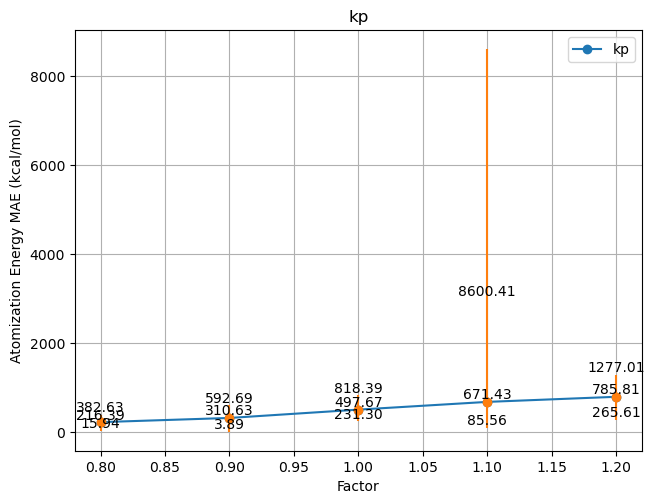

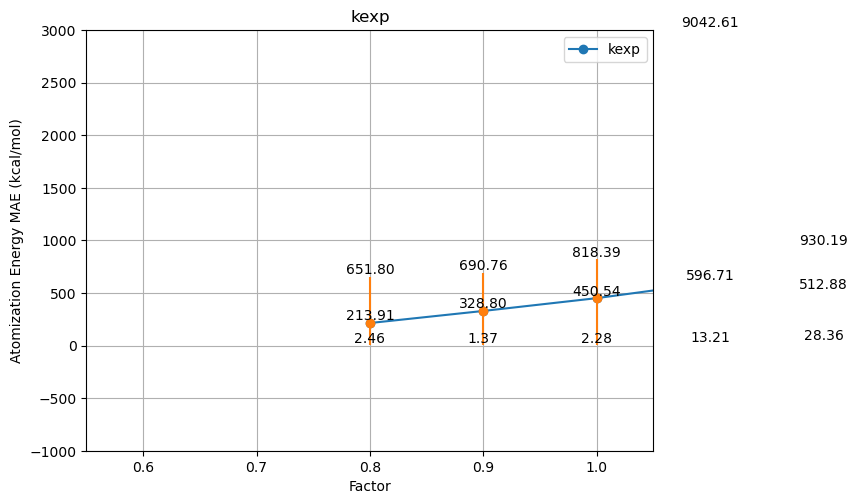

In [40]:
selected_parameters = ["kp", "kexp"]

for i, parameter in enumerate(results_df["parameter"].unique()):
    if parameter not in selected_parameters:
        continue

    aggregated_fig, aggregated_axs = plt.subplots()
    aggregated_fig.tight_layout()

    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    max_errors = []
    min_errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]

        errors.append((factor, factor_df["Atomization Energy MAE (kcal/mol)"].abs().mean()))
        max_errors.append(
            (
                factor,
                factor_df["Atomization Energy MAE (kcal/mol)"].abs().max()
                - factor_df["Atomization Energy MAE (kcal/mol)"].abs().mean(),
            )
        )
        min_errors.append(
            (
                factor,
                factor_df["Atomization Energy MAE (kcal/mol)"].abs().mean()
                - factor_df["Atomization Energy MAE (kcal/mol)"].abs().min(),
            )
        )

    errors.sort(key=lambda x: x[0])
    max_errors.sort(key=lambda x: x[0])
    min_errors.sort(key=lambda x: x[0])

    aggregated_axs.plot(
        [x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter
    )
    aggregated_axs.errorbar(
        [x[0] for x in errors],
        [x[1] for x in errors],
        yerr=[[error[1] for error in min_errors], [error[1] for error in max_errors]],
        fmt="o",
    )

    for x, y in zip([x[0] for x in errors], [x[1] for x in errors]):
        if parameter == "kexp" and x < 0.55:
            continue
        aggregated_axs.text(x, y, f"{y:.2f}", ha="center", va="bottom")
    for x, y in zip(
        [x[0] for x in errors], [x1[1] + x2[1] for x1, x2 in zip(errors, max_errors)]
    ):
        if parameter == "kexp" and x < 0.55:
            continue
        aggregated_axs.text(x, min(y, 3000), f"{y:.2f}", ha="center", va="bottom")
    for x, y in zip(
        [x[0] for x in errors], [x1[1] - x2[1] for x1, x2 in zip(errors, min_errors)]
    ):
        if parameter == "kexp" and x < 0.55:
            continue
        aggregated_axs.text(x, y, f"{y:.2f}", ha="center", va="bottom")

    if parameter == "kexp":
        aggregated_axs.set_xlim(0.55, 1.05)
        aggregated_axs.set_ylim(-1000, 3000)

    aggregated_axs.grid(True)
    aggregated_axs.set_title(parameter)
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("Atomization Energy MAE (kcal/mol)")
    aggregated_axs.legend()
    plt.show()

## Geometry

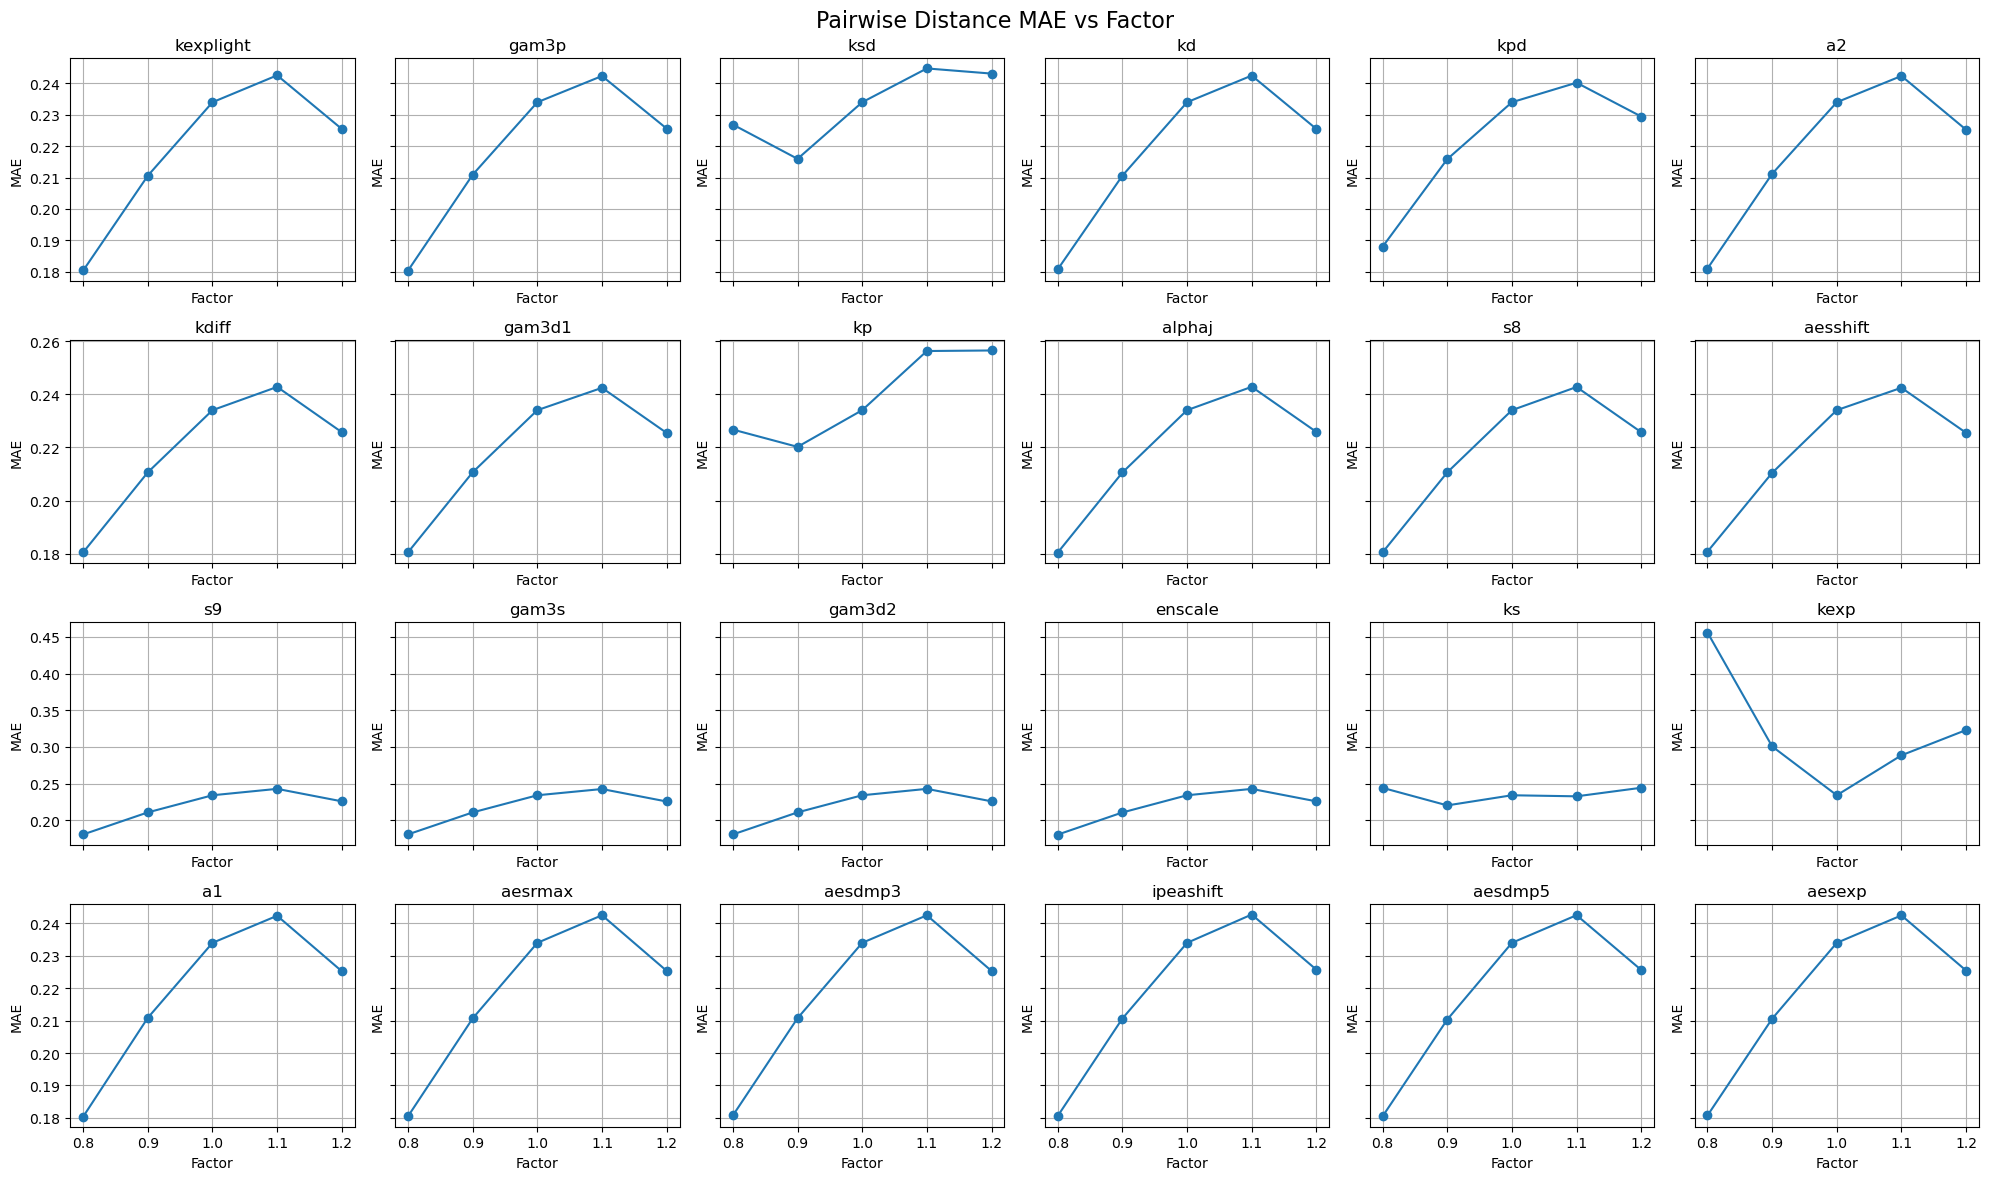

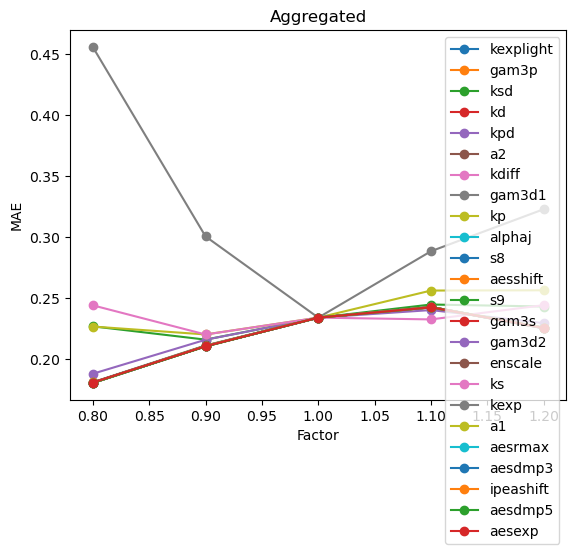

In [41]:
num_rows, num_cols = (4, 6)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

aggregated_fig, aggregated_axs = plt.subplots()

molecule_sets = {}
for factor in results_df["factor"].unique():
    factor_df = results_df[results_df["factor"] == factor]
    molecule_sets[factor] = factor_df["molecule"].unique()
    for parameter in factor_df["parameter"].unique():
        parameter_df = factor_df[factor_df["parameter"] == parameter]
        molecule_sets[factor] = np.intersect1d(
            molecule_sets[factor], parameter_df["molecule"].unique()
        )

for i, parameter in enumerate(results_df["parameter"].unique()):
    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]
        factor_df = factor_df[factor_df["molecule"].isin(molecule_sets[factor])]

        errors.append((factor, factor_df["Pairwise Distance MAE"].abs().mean()))

    ax = axs[i // num_cols, i % num_cols]

    errors.sort(key=lambda x: x[0])

    ax.plot([x[0] for x in errors], [x[1] for x in errors], marker="o")
    aggregated_axs.plot(
        [x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter
    )

    ax.set_title(parameter)
    ax.set_xlabel("Factor")
    ax.set_ylabel("MAE")

    ax.grid(visible=True)

    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE")
    aggregated_axs.legend()

fig.suptitle("Pairwise Distance MAE vs Factor", fontsize=16)
fig.tight_layout()

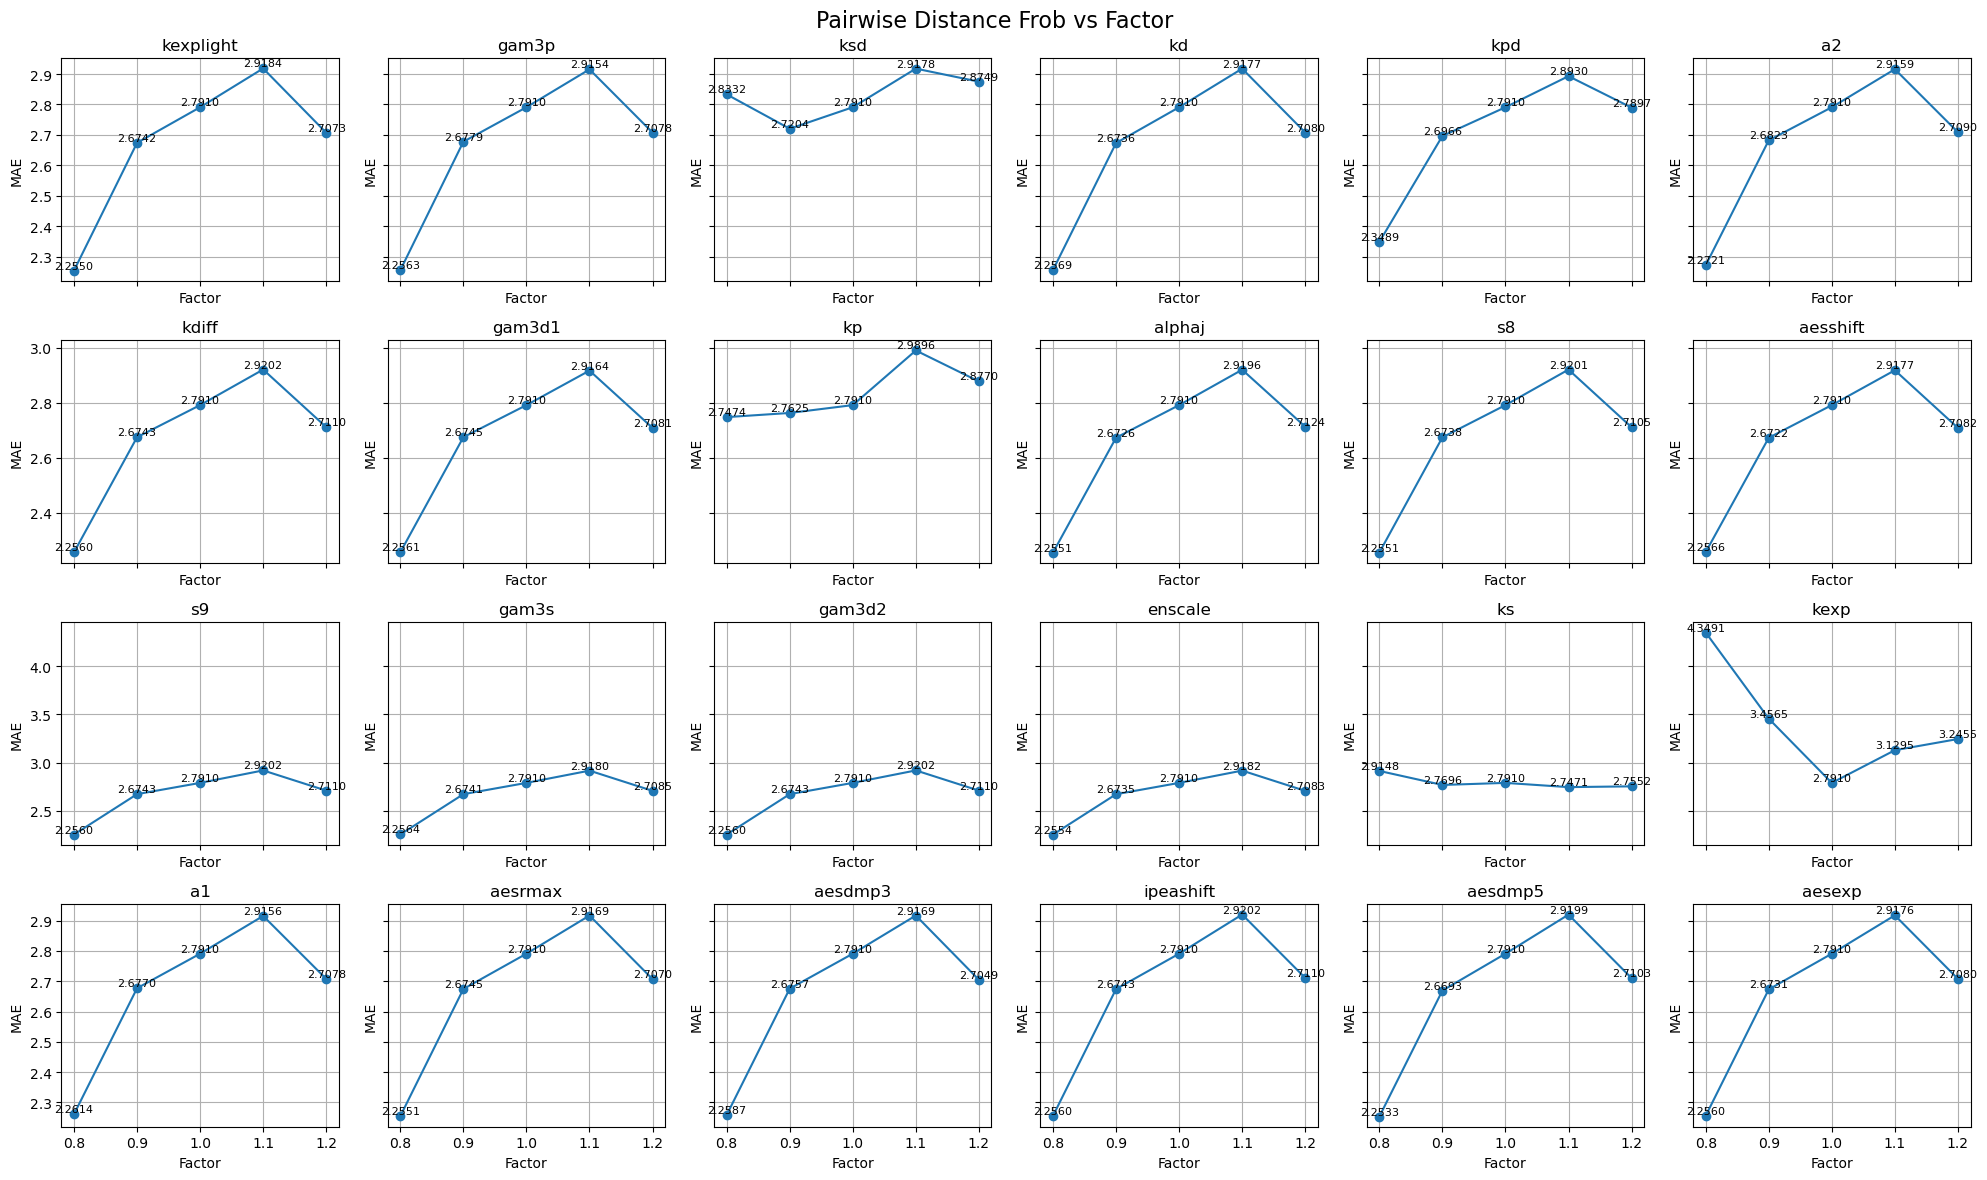

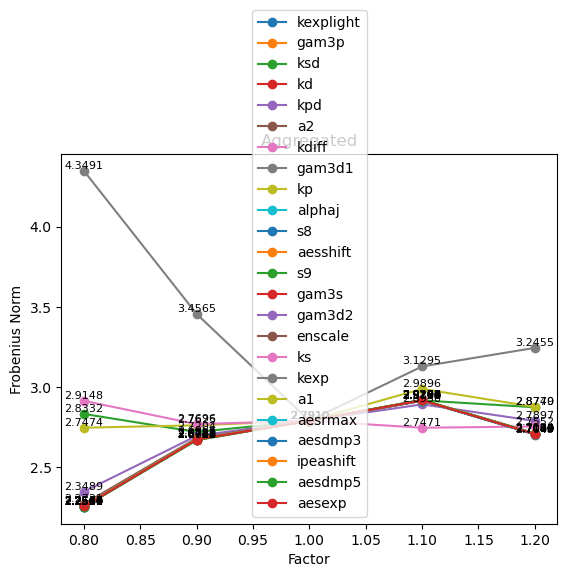

In [50]:
num_rows, num_cols = (4, 6)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey="row")

aggregated_fig, aggregated_axs = plt.subplots()

molecule_sets = {}
for factor in results_df["factor"].unique():
    factor_df = results_df[results_df["factor"] == factor]
    molecule_sets[factor] = factor_df["molecule"].unique()
    for parameter in factor_df["parameter"].unique():
        parameter_df = factor_df[factor_df["parameter"] == parameter]
        molecule_sets[factor] = np.intersect1d(
            molecule_sets[factor], parameter_df["molecule"].unique()
        )

for i, parameter in enumerate(results_df["parameter"].unique()):
    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]
        factor_df = factor_df[factor_df["molecule"].isin(molecule_sets[factor])]
        errors.append(
            (factor, factor_df["Pairwise Distance Frobenius Norm"].abs().mean())
        )

    ax = axs[i // num_cols, i % num_cols]
    errors.sort(key=lambda x: x[0])

    x_vals = [x[0] for x in errors]
    y_vals = [x[1] for x in errors]

    # Plot points
    ax.plot(x_vals, y_vals, marker="o")
    aggregated_axs.plot(x_vals, y_vals, marker="o", label=parameter)

    # Add text labels to each point
    for x, y in zip(x_vals, y_vals):
        ax.text(x, y, f"{y:.4f}", ha="center", va="bottom", fontsize=8)
        aggregated_axs.text(x, y, f"{y:.4f}", ha="center", va="bottom", fontsize=8)

    ax.set_title(parameter)
    ax.set_xlabel("Factor")
    ax.set_ylabel("MAE")
    ax.grid(visible=True)

    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("Frobenius Norm")
    aggregated_axs.legend()

fig.suptitle("Pairwise Distance Frob vs Factor", fontsize=16)
fig.tight_layout()

## Find Sensitive Molecule

In [ ]:
results_df.head()

sensitive_molecules = {}

for parameter in selected_parameters:
    parameter_df = results_df[results_df["parameter"] == parameter]

    diffs = []

    for molecule in parameter_df["molecule"].unique():
        molecule_df = parameter_df[parameter_df["molecule"] == molecule]

        molecule_df.sort_values("factor", inplace=True)

        diffs.append((molecule, molecule_df['error'].diff().abs().mean()))

    diffs.sort(key=lambda x: x[1], reverse=True)

    sensitive_molecules[parameter] = diffs[0]

sensitive_molecules

/var/folders/3m/2lzp5b051qd01070jvyf9zw80000gn/T/ipykernel_14644/2419524912.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molecule_df.sort_values("factor", inplace=True)


KeyError: 'error'

In [ ]:
selected_parameters = ['kexp']

aggregated_fig, aggregated_axs = plt.subplots()
aggregated_fig.tight_layout()

for i, parameter in enumerate(selected_parameters):
    parameter_df = results_df[results_df["parameter"] == parameter]

    parameter_df = parameter_df[parameter_df["molecule"] == sensitive_molecules[parameter][0]]

    errors = []
    max_errors = []
    min_errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]

        errors.append((factor, factor_df["error"].abs().mean()))

    errors.sort(key=lambda x: x[0])

    aggregated_axs.plot([x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter)
    
    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE")
    aggregated_axs.legend()
plt.show()

In [ ]:
errors